In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.interpolate import splrep, splev
from scipy.interpolate import CubicHermiteSpline
from scipy.signal import argrelextrema
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d, CubicSpline

In [1152]:
road_traffic = pd.read_csv('road_traffic.csv')
stocks_data = pd.read_csv('stocks_data.csv')
energy_consumption = pd.read_csv('temperature_and_energy_consumption.csv')

In [1153]:
data_numeric = road_traffic.drop(columns=['Date', 'Time', 'Local Time (Sensor)', 'countlineName', 'direction']) 
imputer = SimpleImputer(strategy='mean')
road_traffic_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)

label_encoder = LabelEncoder()
categorical_columns = road_traffic.select_dtypes(include=['object']).columns
for col in categorical_columns:
    road_traffic_imputed[col] = label_encoder.fit_transform(road_traffic[col])
    

energy_consumption['time_n'] = pd.to_datetime(energy_consumption['time_n'])
energy_consumption['day'] = (energy_consumption['time_n'] - energy_consumption['time_n'].min()).dt.days
 
    

# Zadanie 3

In [1154]:
def generate_weather_data(num_stations, num_days):
    """
    Funkcja generuje przykładowe dane meteorologiczne dla wielu stacji pomiaro-
    wych i dni i zapisuje je do pliku CSV.
    Parametry:
    - num_stations: liczba stacji pomiarowych
    - num_days: liczba dni pomiarowych
    Zwraca:
    - None
    """
    # Temperatury miesięczne dla stacji 1
    temperatures1 = np.array([-2, 0, 5, 12, 18, 23, 26, 25, 21, 15, 8, 2])
    # Generowanie danych dla stacji 1
    np.random.seed(0)
    dates = pd.date_range(start='2023-01-01', periods=num_days)
    station_ids = ['Station_' + str(i) for i in range(1, num_stations + 1)]
    data = {station: [] for station in station_ids}
    for day in range(num_days):
        month = dates[day].month - 1 # Indeksowanie od zera
        temperature1 = temperatures1[month]
    # Generowanie danych dla pozostałych stacji z odchyłkami
        for station in station_ids:
            temperature = temperature1 + np.random.uniform(low=-2,high=2) if station == 'Station_1' else temperature1 + np.random.uniform(low=-4, high=4)
            if day > 0 and np.random.rand() < 0.05: # Rzadkie skoki temperatury
                temperature += np.random.uniform(low=-10, high=10)
            data[station].append(temperature)
    # Utworzenie ramki danych
    df = pd.DataFrame(data)
    df['Date'] = dates
    df = df[['Date'] + station_ids]
    # Zapisanie danych do pliku CSV
    df.to_csv('weather_data.csv', index=False)
    
generate_weather_data(num_stations=5, num_days=15)

In [1155]:
data = pd.read_csv('weather_data.csv')

print(data.head())
print(data.info())

data_numeric = data.drop(columns=['Date'])
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)

label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data_imputed[col] = label_encoder.fit_transform(data[col])

print("\nPrzetworzone dane:")
print(data_imputed.head())


         Date  Station_1  Station_2  Station_3  Station_4  Station_5
0  2023-01-01  -1.804746  -0.278485  -1.177893  -1.640935  -2.610762
1  2023-01-02  -1.416424   1.134184  -2.932468  -1.768841   1.404773
2  2023-01-03   3.000914   0.225254   1.828947  -2.308165  -5.053805
3  2023-01-04  -3.426587  -1.825213  -3.883555  -2.350797  -5.849682
4  2023-01-05  -1.551617   1.549985  -3.123937  -0.418950  -0.665866
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15 non-null     object 
 1   Station_1  15 non-null     float64
 2   Station_2  15 non-null     float64
 3   Station_3  15 non-null     float64
 4   Station_4  15 non-null     float64
 5   Station_5  15 non-null     float64
dtypes: float64(5), object(1)
memory usage: 848.0+ bytes
None

Przetworzone dane:
   Station_1  Station_2  Station_3  Station_4  Station_5  Date
0  -1.804746  -0.27

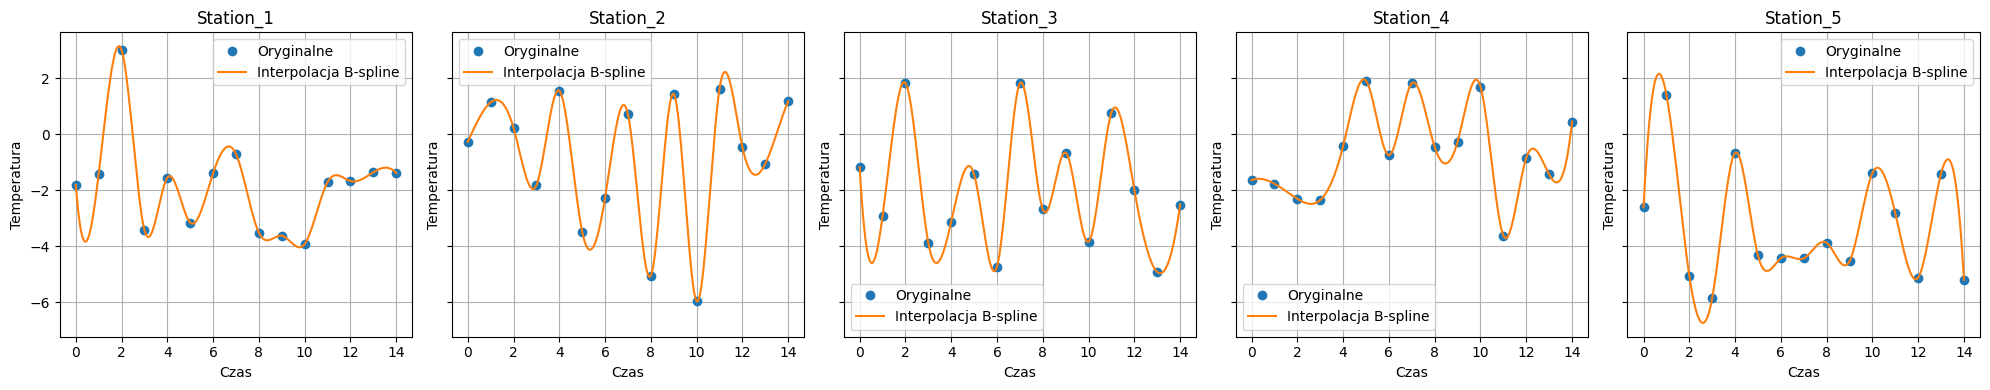

In [1156]:
x = np.arange(len(data_imputed))
x_new = np.linspace(0, len(data_imputed)-1, 300)

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # 1 rząd, 5 kolumn


for i, station in enumerate(data_imputed.columns[:-1]):
    y = data_imputed[station]
    spl = splrep(x, y, s=0)
    y_new = splev(x_new, spl)

    axs[i].plot(x, y, 'o', label='Oryginalne')
    axs[i].plot(x_new, y_new, '-', label='Interpolacja B-spline')
    axs[i].set_title(station)
    axs[i].set_xlabel('Czas')
    axs[i].set_ylabel('Temperatura')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


# Zadadnie 4

MSE dla interpolacji wielomianowej: 268131.70
MSE dla interpolacji liniowej: 198155.21


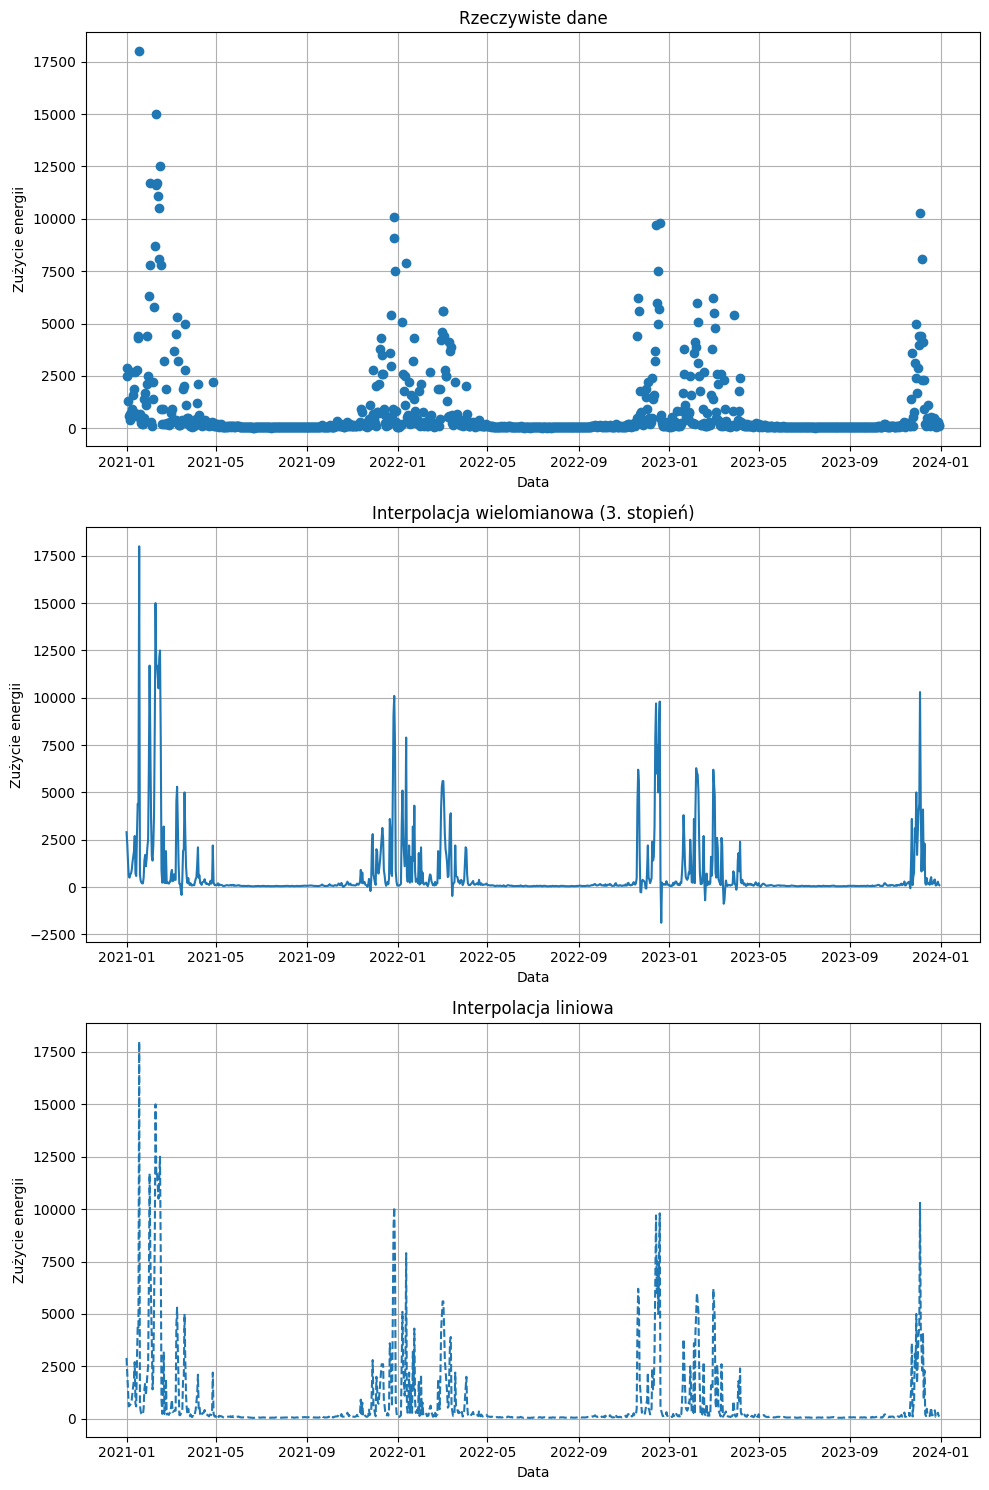

In [1157]:
x = energy_consumption['day'].values
y = energy_consumption['energy_consumption'].values

energy_consumption_train = energy_consumption.copy()
energy_consumption_train.loc[np.random.choice(energy_consumption_train.index+1, size=int(len(energy_consumption_train) * 0.2)), 'energy_consumption'] = np.nan

y_pred_poly = energy_consumption_train['energy_consumption'].interpolate(method='polynomial', order=3)
y_pred_linear = energy_consumption_train['energy_consumption'].interpolate(method='linear')

valid_idx = ~np.isnan(y) & ~np.isnan(y_pred_poly)
mse_poly = mean_squared_error(y[valid_idx], y_pred_poly[valid_idx])
mse_linear = mean_squared_error(y[valid_idx], y_pred_linear[valid_idx])

print(f"MSE dla interpolacji wielomianowej: {mse_poly:.2f}")
print(f"MSE dla interpolacji liniowej: {mse_linear:.2f}")

fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].plot(energy_consumption['time_n'], y, 'o', label='Rzeczywiste dane')
axs[0].set_title('Rzeczywiste dane')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Zużycie energii')
axs[0].grid(True)

axs[1].plot(energy_consumption['time_n'], y_pred_poly, '-', label='Interpolacja wielomianowa (3. stopień)')
axs[1].set_title('Interpolacja wielomianowa (3. stopień)')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Zużycie energii')
axs[1].grid(True)

axs[2].plot(energy_consumption['time_n'], y_pred_linear, '--', label='Interpolacja liniowa')
axs[2].set_title('Interpolacja liniowa')
axs[2].set_xlabel('Data')
axs[2].set_ylabel('Zużycie energii')
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Zadanie 5

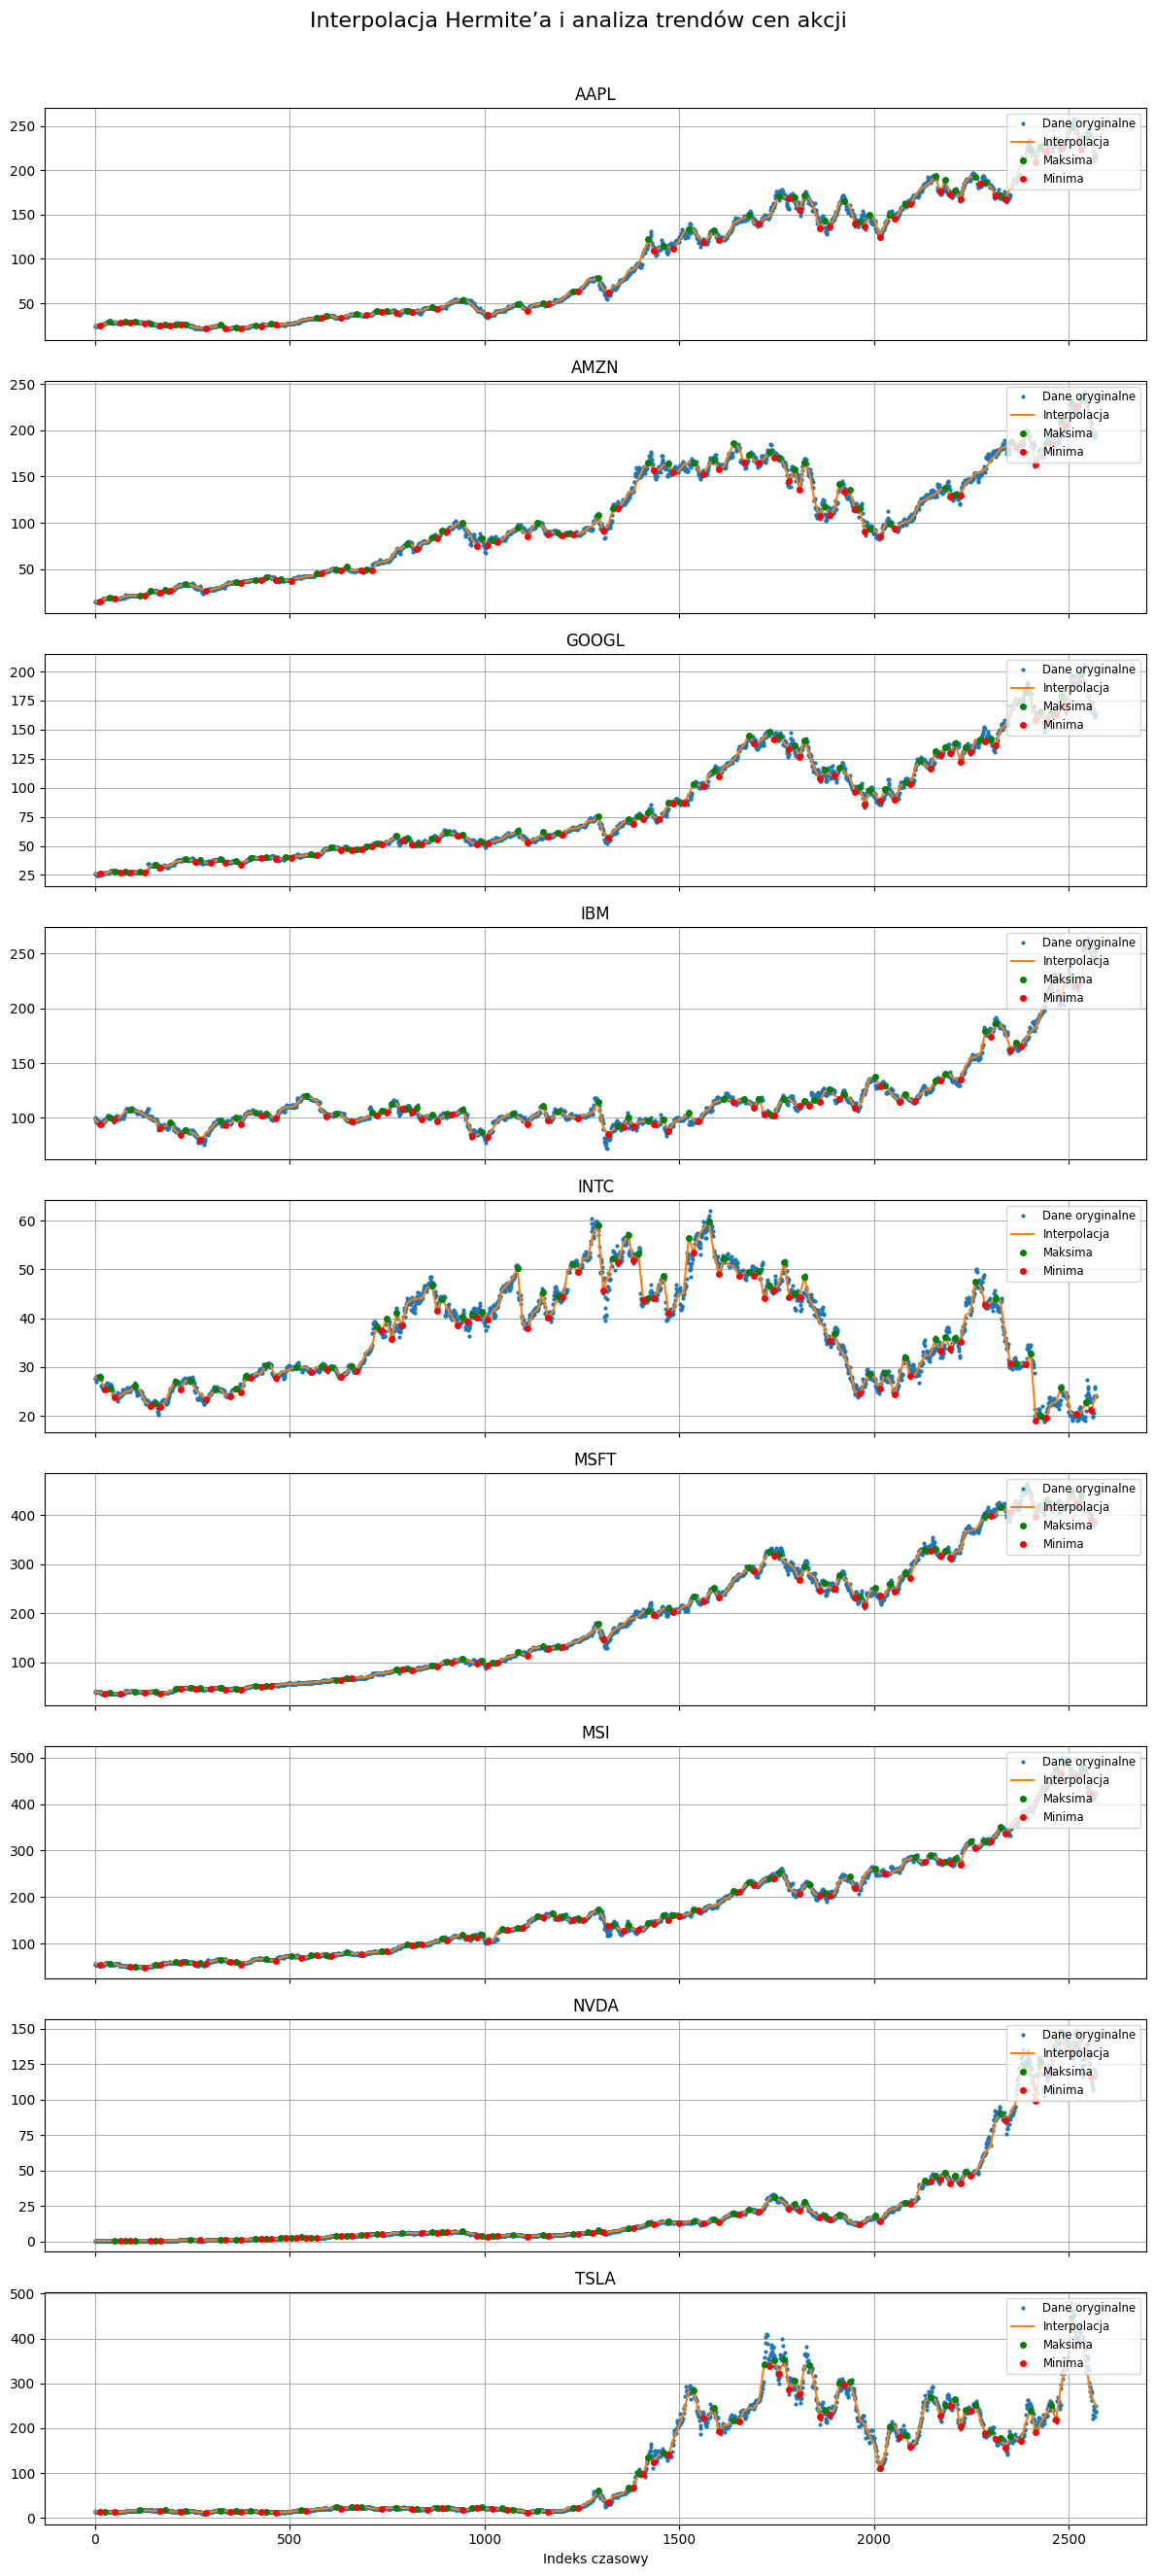

In [1158]:
stocks_data = pd.read_csv('stocks_data.csv')
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])

companies = [col for col in stocks_data.columns if col != 'Date']
Interpolation_degree = 200
x = np.arange(len(stocks_data))

fig, axs = plt.subplots(len(companies), 1, figsize=(12, 3 * len(companies)), sharex=True)

for i, company in enumerate(companies):
    y = stocks_data[company].values
    dy_dx = np.gradient(y, x)
    
    spline = CubicHermiteSpline(x, y, dy_dx)
    x_fine = np.linspace(x.min(), x.max(), Interpolation_degree)
    y_interp = spline(x_fine)

    max_idx = argrelextrema(y_interp, np.greater)[0]
    min_idx = argrelextrema(y_interp, np.less)[0]

    axs[i].plot(x, y, 'o', markersize=2, label='Dane oryginalne')
    axs[i].plot(x_fine, y_interp, '-', label='Interpolacja')
    axs[i].plot(x_fine[max_idx], y_interp[max_idx], 'go', markersize=4, label='Maksima')
    axs[i].plot(x_fine[min_idx], y_interp[min_idx], 'ro', markersize=4, label='Minima')
    axs[i].set_title(f'{company}')
    axs[i].grid(True)
    axs[i].legend(loc='upper right', fontsize='small')

plt.xlabel('Indeks czasowy')
fig.suptitle('Interpolacja Hermite’a i analiza trendów cen akcji', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Zadanie 6

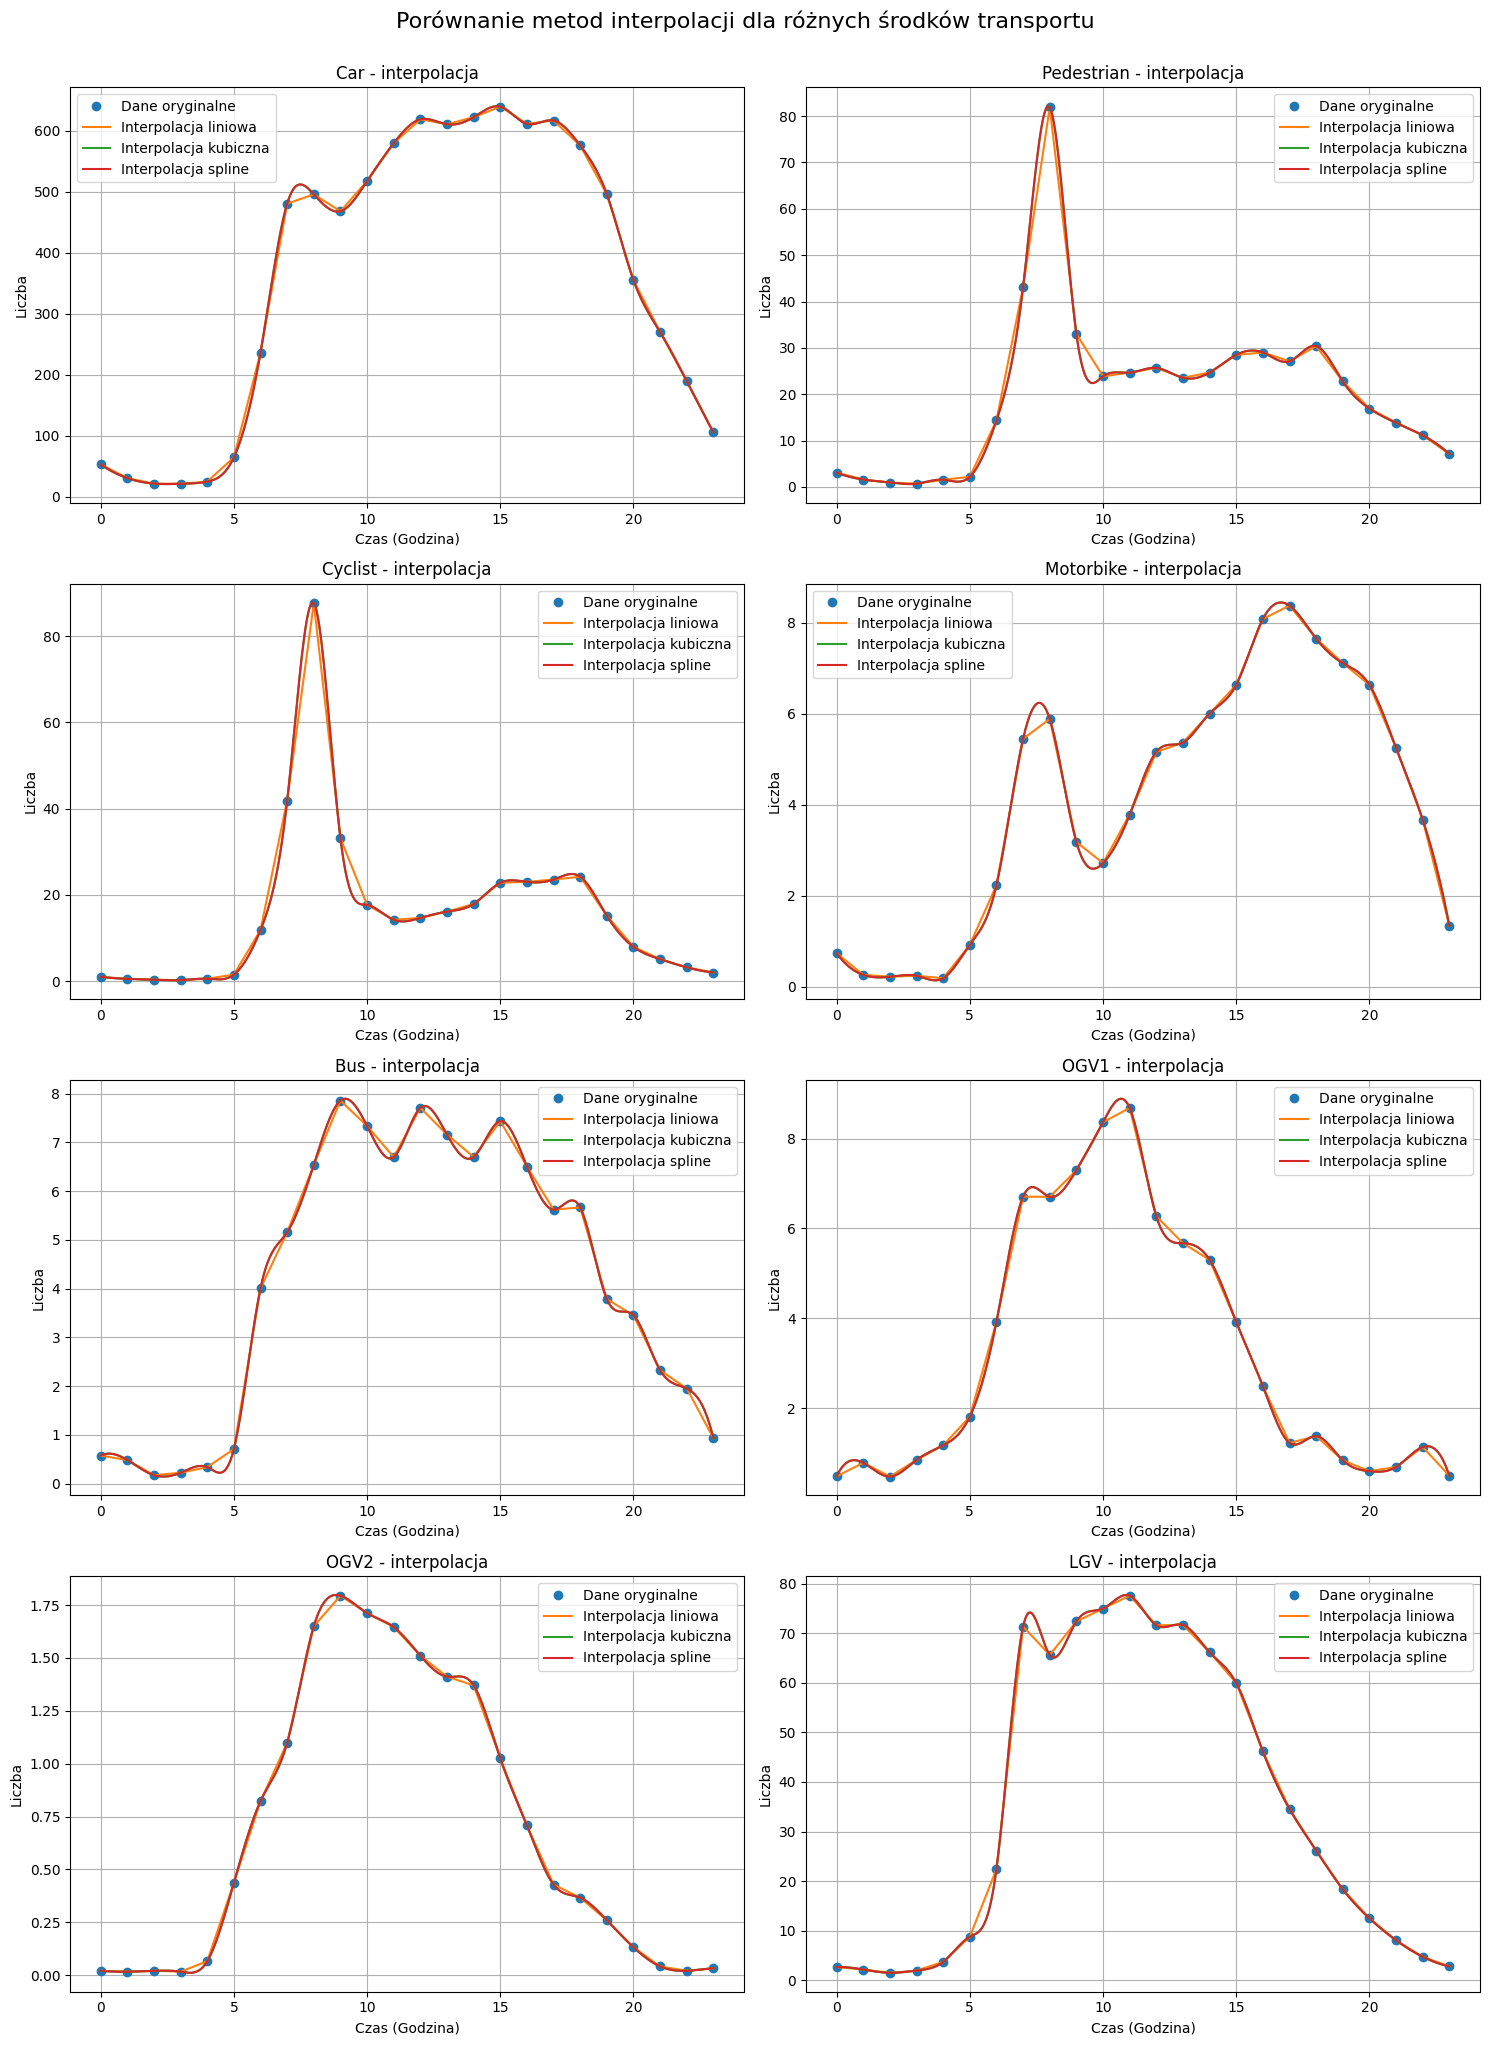

In [1159]:
transport_modes = ['Car', 'Pedestrian', 'Cyclist', 'Motorbike', 'Bus', 'OGV1', 'OGV2', 'LGV']
road_traffic_in = road_traffic_imputed[road_traffic_imputed['direction'] == 1]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axs = axs.flatten()

for i, mode in enumerate(transport_modes):
    road_traffic_agg = road_traffic_in.groupby("Time")[mode].mean().reset_index()
    x = road_traffic_agg['Time'].values
    y = road_traffic_agg[mode].values

    linear_interp = interp1d(x, y, kind='linear', fill_value="extrapolate")
    cubic_interp = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    spline_interp = CubicSpline(x, y)

    x_new = np.linspace(x.min(), x.max(), 500)
    y_linear = linear_interp(x_new)
    y_cubic = cubic_interp(x_new)
    y_spline = spline_interp(x_new)

    ax = axs[i]
    ax.plot(x, y, 'o', label='Dane oryginalne')
    ax.plot(x_new, y_linear, label='Interpolacja liniowa')
    ax.plot(x_new, y_cubic, label='Interpolacja kubiczna')
    ax.plot(x_new, y_spline, label='Interpolacja spline')
    ax.set_title(f"{mode} - interpolacja")
    ax.set_xlabel("Czas (Godzina)")
    ax.set_ylabel("Liczba")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle("Porównanie metod interpolacji dla różnych środków transportu", fontsize=16, y=1.02)
plt.show()
